# Calibrating a SABR model on toy market data - a practical example
In this example, we will go through the logic of fitting a SABR model on observed market data.
A SABR model has the goal of quantifying the variation in volatility based on the strike price of an option. The paper that introduced the SABR model, written by Hagan (2002), states that the volatility of an option can be estimated via the following formula:

$$\sigma(f, K) = \frac{\alpha}{(fK)^{(1-\beta)/2}\left\{1 + \frac{(1-\beta)^2}{24}\log^2{f/K} + \frac{(1-\beta)^4}{1920}\log^4{f/K} + \epsilon_1\right\}} \cdot \left(\frac{z}{x(z)}\right) \cdot \left\{1 + \left[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{(fK)^{1-\beta}} + \frac{1}{4}\frac{\rho\beta\nu\alpha}{(fK)^{(1-\beta)/2}} + \frac{1-3\rho^2}{24}\nu^2\right]t_{ex} + \epsilon_2\right\}$$

Where the function is governed by the unknown parameters: 
- $\alpha > 0$, 
- $0 \leq \beta \leq 1$, 
- $-1 \leq \rho \leq 1$, 
- $\nu > 0$ 

Calibrating a SABR model means to find the combination of parameters $(\alpha, \beta, \rho, \nu)$ so that equation (1) best interpolates the **observed** market volatilities for the different strike prices. There are various algorithms to estimate these paramenters - in our `SABR_swaption` class we implemented two: Sequential Least Squares Programming and Differential Evolution (although they give out almost identical results).

NOTE: the SABR model can be easily applied to swaptions derivatives - the strike price simply becomes the rate of the option.

## Our Data
Our data is a 36-row dataframe. Each row corresponds to a different swaption.
Each swaption is characterized by:
- **Tenor**
- **Expiry**
- **Forward Rate (fwd)**

And by 9 strike rate spreads (in bps), which represent the difference (spread) between the forward rate minus the strike rate. Each cell in the dataframe represents the observed market volatility for that combination of swaption-strike.

In [1]:
from SABR import SABR_swaption, SABR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

In [2]:
df = pd.read_excel("market_data.xlsx", skiprows=1)
df.head()

,Tenor,Expiry,Fwd,-150,-100,-50,-25,0,25,50,100,150
0,2.0,0.25,0.010764,0.0,1.0470,0.4812,0.4327,0.4268,0.4148,0.4253,0.4322,0.4495
1,2.0,0.50,0.011099,0.0,0.9647,0.5079,0.4637,0.4477,0.4390,0.4377,0.4452,0.4576
2,2.0,0.75,0.011602,0.0,0.8253,0.5033,0.4648,0.4494,0.4387,0.4348,0.4375,0.4463
3,2.0,1.00,0.012194,0.0,0.6796,0.4788,0.4474,0.4501,0.4435,0.4478,0.4611,0.4754
4,2.0,2.00,0.016196,0.0,0.9119,0.5417,0.4628,0.4529,0.4461,0.4386,0.4387,0.4442


## Step 1
Extract:
- The observed market volatilities' table, `vols`
- The strike rates' table, `K`. In our example, the strike is equal to $fwd + spread*0.0001$

In [3]:
expiries = df.Expiry.tolist()
spreads = df.columns.difference(["Tenor", "Expiry", "Fwd"]).tolist()
F = df.Fwd.tolist()

vols = df.loc[:, spreads] # isolate the market volatilities in a DataFrame

K = pd.DataFrame(index = F, columns=spreads)
for spread in spreads:
    for f in F:
        K.loc[f, spread] = f + 0.0001*spread

K.head()

,-150,-100,-50,-25,0,25,50,100,150
0.010764,-0.00423617,0.000763833,0.00576383,0.00826383,0.0107638,0.0132638,0.0157638,0.0207638,0.0257638
0.011099,-0.00390081,0.00109919,0.00609919,0.00859919,0.0110992,0.0135992,0.0160992,0.0210992,0.0260992
0.011602,-0.00339757,0.00160243,0.00660243,0.00910243,0.0116024,0.0141024,0.0166024,0.0216024,0.0266024
0.012194,-0.00280644,0.00219356,0.00719356,0.00969356,0.0121936,0.0146936,0.0171936,0.0221936,0.0271936
0.016196,0.00119598,0.00619598,0.011196,0.013696,0.016196,0.018696,0.021196,0.026196,0.031196


## Step 2
Fit the model on the first swaption observed.

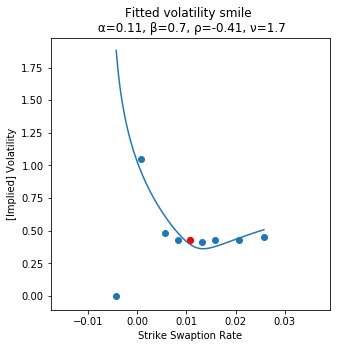

In [4]:
i = 0

model = SABR_swaption(F = F[i], # forward rate, scalar
                      K = K.values[i], # strikes, vector (N X 1)
                      time = expiries[i], # expiry (in yrs), scalar
                      vols = vols.values[i], # observed market volatilities, vector (N X 1)
                      calibration="DE_SciPy",
                      beta = 0.7)

model.plot_smile()

print out the predicted volatilities for each one of the input strike prices.

In [5]:
model.predict()

[1.881928766446739,
 0.9563331626980475,
 0.6061404258829297,
 0.4842008835225031,
 0.3956508657935604,
 0.36211075330395104,
 0.37776624845509005,
 0.4445190178725681,
 0.507952792934953]

## Analysis on all swaptions
We are interested in:
- The volatility predictions for each swaption, `pred_vols`
- The errors on our volatility predictions with respect to the observed ones, `residuals`
- The coefficients alpha, beta, rho, nu of each curve and the shape of each one of these curves (summarized in a plot)

In [6]:
models = []

for i in range(len(F)):
    model = SABR_swaption(F = F[i],
                      K = K.values[i],
                      time = expiries[i],
                      vols = vols.values[i],
                      calibration="DE_SciPy",
                      beta=0.7)
    models.append(model)

Let's now plot the curves for all swaptions

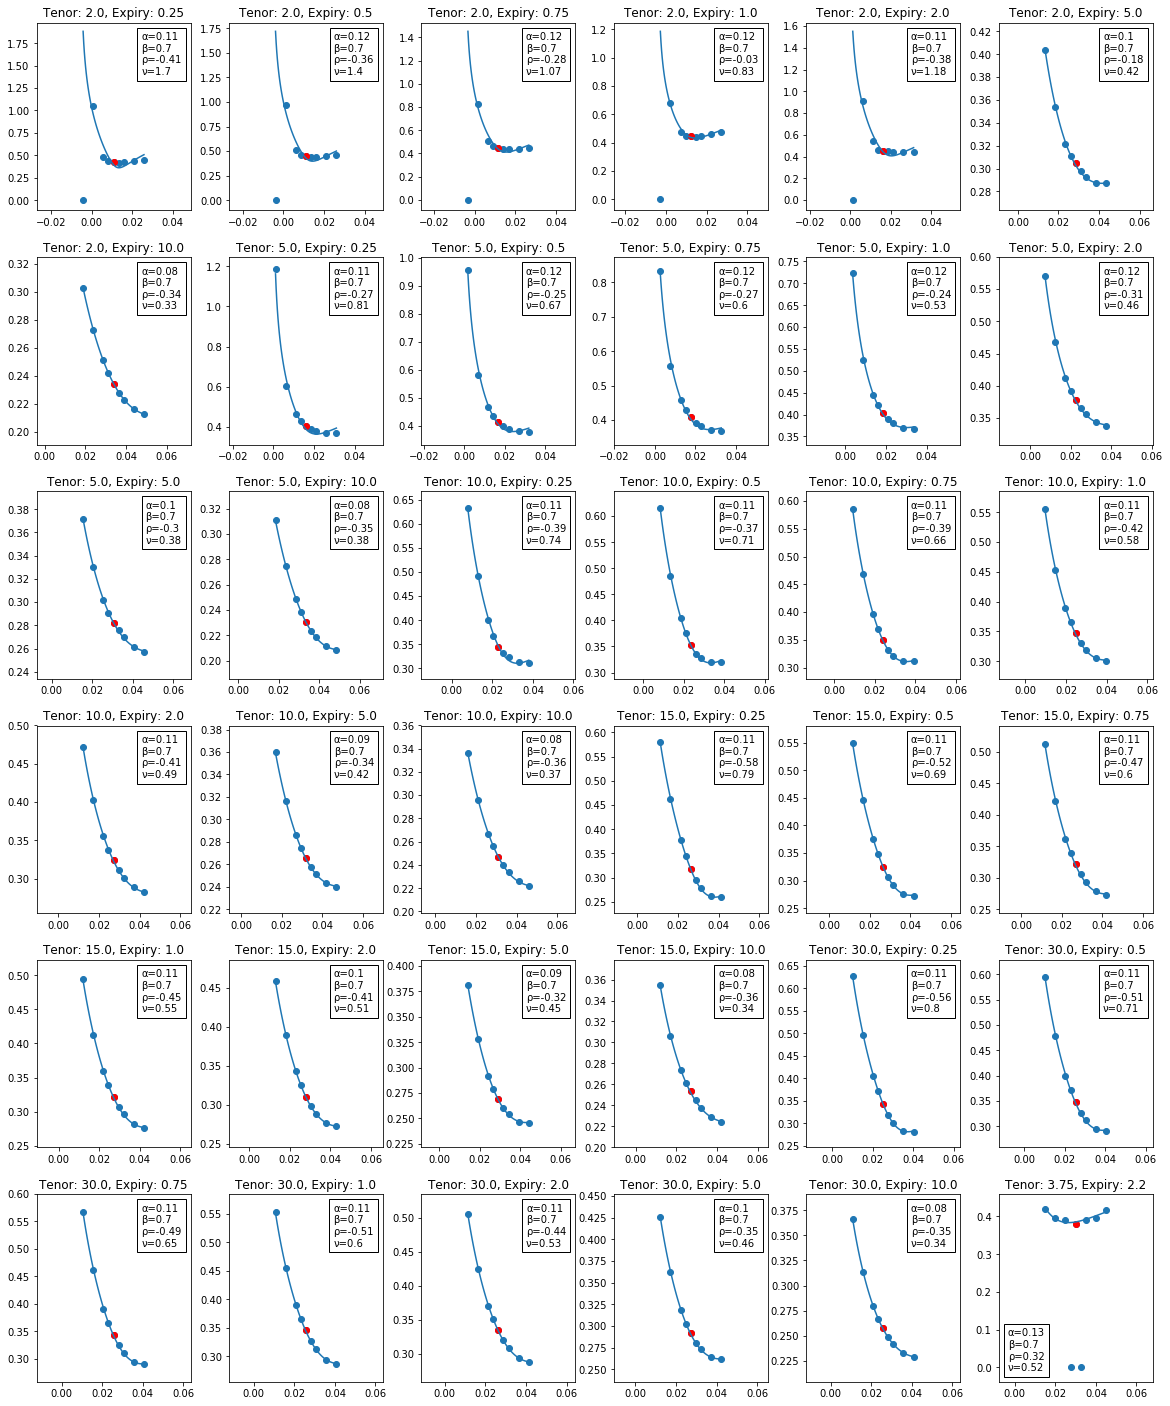

In [7]:
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(20,25), squeeze=True, gridspec_kw={'hspace': 0.25, 'wspace': 0.25})
ax = ax.flatten()
#fig.tight_layout()

for i in range(len(models)):
    
    # first, create a linspace on the SHIFTED strike prices
    x = np.linspace(np.min(models[i].K), np.max(models[i].K), num=100) + models[i].shift
    # then, estimate volatilities on that linspace
    y = [SABR(models[i].alpha, models[i].beta, models[i].rho, models[i].nu, models[i].F, k, models[i].time) for k in x]
    # lastly, un-shift the linspace
    x -= models[i].shift
    
    ax[i].set_title(f"Tenor: {df.Tenor[i]}, Expiry: {df.Expiry[i]}")
    ax[i].scatter(x = models[i].K, y = models[i].vols)
    ax[i].scatter(x = models[i].K[len(models[i].K)//2], y = models[i].vols[len(models[i].K)//2], c="r")
    ax[i].plot(x, y)
    
    loc = 1 if i < (len(models) - 1) else 3 # last plot gets covered
    ax[i].add_artist(AnchoredText(f"α={round(models[i].alpha, 2)}\nβ={round(models[i].beta, 2)}\nρ={round(models[i].rho, 2)}\nν={round(models[i].nu, 2)}", loc=loc))

In [8]:
pred_vols = np.array([np.array(model.predict()) for model in models])
pred_vols = pd.DataFrame(pred_vols, columns=spreads)

pred_vols.head()

,-150,-100,-50,-25,0,25,50,100,150
0,1.881703,0.956264,0.606141,0.484232,0.395706,0.362159,0.377787,0.444500,0.507911
1,1.720241,0.901713,0.598727,0.498026,0.428319,0.398466,0.403232,0.449670,0.500310
2,1.452098,0.790866,0.556741,0.484248,0.436796,0.414760,0.413123,0.438202,0.471875
3,1.185636,0.666276,0.501167,0.459283,0.438140,0.433083,0.438201,0.461250,0.487902
4,1.551717,0.865579,0.595163,0.505403,0.442259,0.410546,0.407380,0.439668,0.481526


In [9]:
residuals = pred_vols[vols != 0] - vols[vols != 0]
residuals.head()

,-150,-100,-50,-25,0,25,50,100,150
0,NaN,-0.090736,0.124941,0.051532,-0.031094,-0.052641,-0.047513,0.012300,0.058411
1,NaN,-0.062987,0.090827,0.034326,-0.019381,-0.040534,-0.034468,0.004470,0.042710
2,NaN,-0.034434,0.053441,0.019448,-0.012604,-0.023940,-0.021677,0.000702,0.025575
3,NaN,-0.013324,0.022367,0.011883,-0.011960,-0.010417,-0.009599,0.000150,0.012502
4,NaN,-0.046321,0.053463,0.042603,-0.010641,-0.035554,-0.031220,0.000968,0.037326


Average MSE across the dataset:

In [10]:
msrs = []
for i in range(len(residuals)):
    vals = residuals.loc[i, :].values
    vals = vals[~np.isnan(vals)]
    
    msrs.append(np.mean(np.abs(vals)))

print(f"Mean residual across the 36 swaptions: {np.mean(msrs)}")

Mean residual across the 36 swaptions: 0.0065714194257538855


### Add the ["Tenor", "Expiry", "Fwd"] columns to output dataframes
We define a function to make the code less messy

In [11]:
def add_data(d):
    """
    Adds ["Tenor", "Expiry", "Fwd"] columns to a dataframe d,
    provided that lengths match.
    """
    # Add ["Tenor", "Expiry", "Fwd"] columns to df
    d = pd.merge(d, df.loc[:, ["Tenor", "Expiry", "Fwd"]], left_index=True, right_index=True)
    # reorder columms
    cols = [col for col in d.columns if col not in ["Tenor", "Expiry", "Fwd"]]
    d = d[["Tenor", "Expiry", "Fwd"] + cols]
    
    return d

In [12]:
pred_vols_final = add_data(pred_vols)
pred_vols_final.head()

,Tenor,Expiry,Fwd,-150,-100,-50,-25,0,25,50,100,150
0,2.0,0.25,0.010764,1.881703,0.956264,0.606141,0.484232,0.395706,0.362159,0.377787,0.444500,0.507911
1,2.0,0.50,0.011099,1.720241,0.901713,0.598727,0.498026,0.428319,0.398466,0.403232,0.449670,0.500310
2,2.0,0.75,0.011602,1.452098,0.790866,0.556741,0.484248,0.436796,0.414760,0.413123,0.438202,0.471875
3,2.0,1.00,0.012194,1.185636,0.666276,0.501167,0.459283,0.438140,0.433083,0.438201,0.461250,0.487902
4,2.0,2.00,0.016196,1.551717,0.865579,0.595163,0.505403,0.442259,0.410546,0.407380,0.439668,0.481526


In [13]:
residuals_final = add_data(residuals)
residuals_final.head()

,Tenor,Expiry,Fwd,-150,-100,-50,-25,0,25,50,100,150
0,2.0,0.25,0.010764,NaN,-0.090736,0.124941,0.051532,-0.031094,-0.052641,-0.047513,0.012300,0.058411
1,2.0,0.50,0.011099,NaN,-0.062987,0.090827,0.034326,-0.019381,-0.040534,-0.034468,0.004470,0.042710
2,2.0,0.75,0.011602,NaN,-0.034434,0.053441,0.019448,-0.012604,-0.023940,-0.021677,0.000702,0.025575
3,2.0,1.00,0.012194,NaN,-0.013324,0.022367,0.011883,-0.011960,-0.010417,-0.009599,0.000150,0.012502
4,2.0,2.00,0.016196,NaN,-0.046321,0.053463,0.042603,-0.010641,-0.035554,-0.031220,0.000968,0.037326


In [14]:
coeffs = pd.DataFrame({"alpha": [model.alpha for model in models],
              "beta": [model.beta for model in models], 
              "rho": [model.rho for model in models], 
              "nu": [model.nu for model in models], 
              "mean_error": msrs})
coeffs = add_data(coeffs)

coeffs.head()

,Tenor,Expiry,Fwd,alpha,beta,rho,nu,mean_error
0,2.0,0.25,0.010764,0.110732,0.7,-0.407402,1.695766,0.058646
1,2.0,0.50,0.011099,0.118118,0.7,-0.357227,1.403787,0.041213
2,2.0,0.75,0.011602,0.120678,0.7,-0.280051,1.066443,0.023977
3,2.0,1.00,0.012194,0.120002,0.7,-0.027581,0.827531,0.011525
4,2.0,2.00,0.016196,0.114376,0.7,-0.375959,1.178430,0.032262


In [15]:
# save output datasets

residuals_final.to_csv("residuals.csv")
pred_vols_final.to_csv("pred_vols.csv")
coeffs.to_csv("coefficients.csv")

## Bonus: Calibration via homebrew Differential Evolution

In [13]:
models_homebrew = []

for i in range(12):
    model = SABR_swaption(F = F[i],
                      K = K.values[i],
                      time = expiries[i],
                      vols = vols.values[i],
                      calibration = "DE_homebrew")
    models_homebrew.append(model)

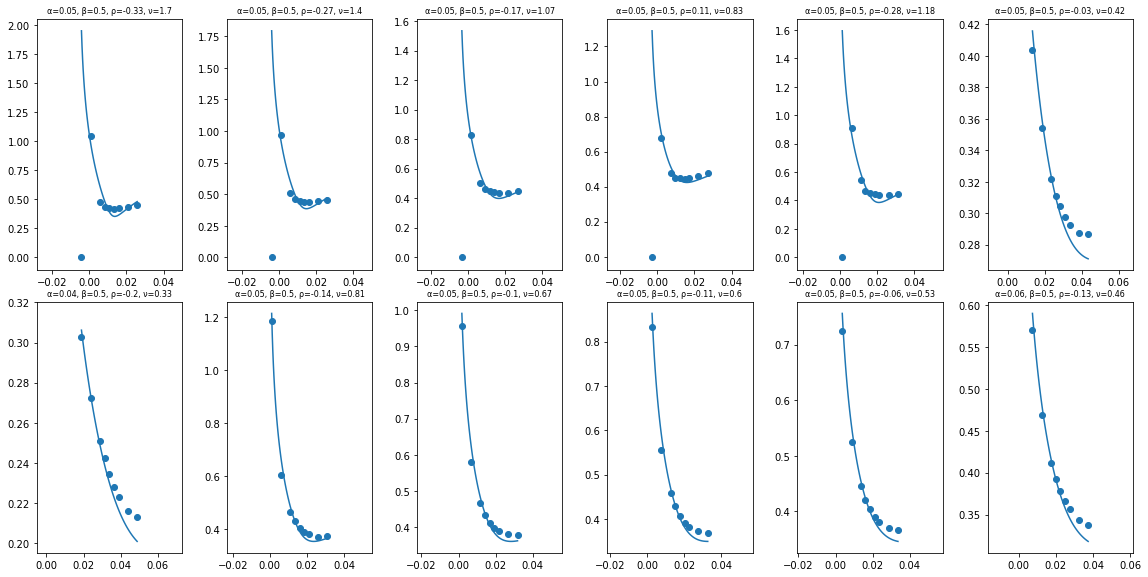

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(16,8), squeeze=True)
ax = ax.flatten()
fig.tight_layout()

for i in range(len(models_homebrew)):
    
    # first, create a linspace on the SHIFTED strike prices
    x = np.linspace(np.min(models_homebrew[i].K), np.max(models_homebrew[i].K), num=100)
    # then, estimate volatilities on that linspace
    y = [SABR(models_homebrew[i].alpha, models_homebrew[i].beta, models[i].rho, models_homebrew[i].nu, models_homebrew[i].F, k, models_homebrew[i].time) for k in x]
    # lastly, un-shift the linspace
    x -= models[i].shift
    
    ax[i].set_title(f"α={round(models_homebrew[i].alpha, 2)}, β={round(models_homebrew[i].beta, 2)}, ρ={round(models_homebrew[i].rho, 2)}, ν={round(models[i].nu, 2)}", fontdict={"fontsize":"8"})
    ax[i].scatter(x = models_homebrew[i].K - models_homebrew[i].shift, y = models_homebrew[i].vols)
    ax[i].plot(x, y)

## Bonus: analysis on parameter variations

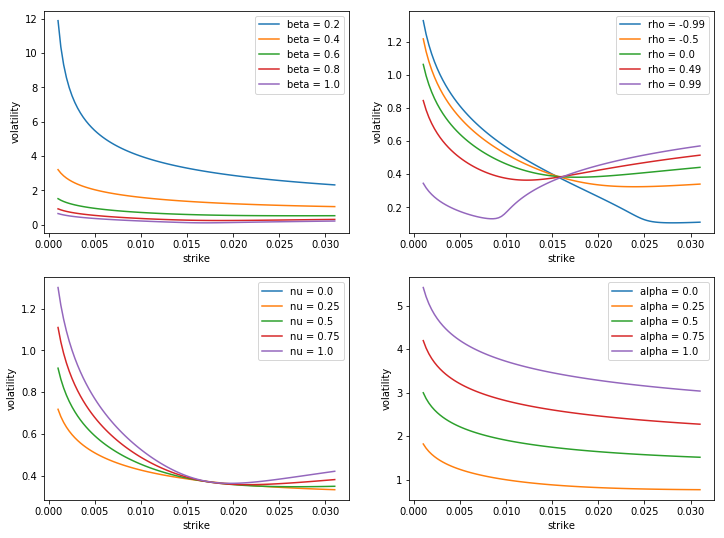

In [86]:
import warnings
warnings.filterwarnings("ignore")

# define the baseline parameters
alpha=0.11
beta=0.7
rho=-0.27
nu=0.81

i = 7
m = models[i]
x = np.linspace(min(m.K), max(m.K), 100)

betas = np.linspace(0.2, 1, 5)
rhos = np.linspace(-0.99, 0.99, 5)
nus = np.linspace(0, 1, 5)
alphas = np.linspace(0, 1, 5)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
ax = ax.flatten()

for i, coeff_list in enumerate([betas, rhos, nus, alphas]):
    for coeff in coeff_list:
        if coeff_list is alphas:
            y = [SABR(coeff, beta, rho, nu, m.F, K=k, time=m.time) for k in x]
            ax[i].plot(x, y, label = f"alpha = {round(coeff, 2)}")
        elif coeff_list is nus:
            y = [SABR(alpha, beta, rho, coeff, m.F, K=k, time=m.time) for k in x]
            ax[i].plot(x, y, label = f"nu = {round(coeff, 2)}")
        elif coeff_list is rhos:
            y = [SABR(alpha, beta, coeff, nu, m.F, K=k, time=m.time) for k in x]
            ax[i].plot(x, y, label = f"rho = {round(coeff, 2)}")
        elif coeff_list is betas:
            y = [SABR(alpha, coeff, rho, nu, m.F, K=k, time=m.time) for k in x]
            ax[i].plot(x, y, label = f"beta = {round(coeff, 2)}")
    ax[i].legend()
    ax[i].set_xlabel("strike")
    ax[i].set_ylabel("volatility")